# Handling upserts and schema evolution on Delta Lake
 `- Ken Tore Tallakstad, Data Engineer, Sherpa by Atea -`

# Delta Lake
## - Open sourced by Databricks, Apr. 2019
> https://delta.io/

## - Data Lake supporting ACID transactions

- **Atomicity**: Guarantees that each transactional unit either succeeds completely, or fails completely
- **Consistency**: Data is always in a valid state. Not the case for Spark/Parquet overwrite: `delete + write` 
- **Isolation**: Isolation of concurrent operations
- **Durability**: Committed data is "never" lost. Implemented by storage layer, HDFS, S3 etc.

## - Streaming and batch: A table in Delta Lake is a batch table as well as a streaming source and sink

## - Schema enforcement: Automatically handles schema variations to prevent insertion of bad records

## - Merge, update and delete operations enables change-data-capture, slowly-changing-dimension support

In [ ]:
# PySpark imports
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf

from delta.tables import *

In [ ]:
sconf = SparkConf()
sconf.set("spark.app.name", "spark-dev")
sconf.set("spark.jars.packages", "io.delta:delta-core_2.11:0.4.0")
sconf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")

spark = ( SparkSession
    .builder
    .config(conf=sconf)
    .enableHiveSupport()
    .getOrCreate()
)

## Spark basic dataframe with schema

In [ ]:
schema = StructType([
  StructField("col1", IntegerType()),
  StructField("col2", StringType()),  
  StructField("col3", DoubleType())])

myDF = spark.createDataFrame([[1, "a,b,c", 2.3],
                              [2, "a,b", 4.4], 
                              [3, "b,c", 3.3], 
                              [4, "b", 4.3], 
                              [5, "h", 6.7]],
                             schema=schema)

myDF.show()

## Create Delta table

In [ ]:
myDF.write.format("delta").save("/home/jovyan/work/data/delta_myDF", mode="overwrite")

### The `_delta_log`
```json
[
  {
    "commitInfo": {
      "timestamp": 1574781132028,
      "operation": "WRITE",
      "operationParameters": {
        "mode": "Overwrite",
        "partitionBy": "[]"
      },
      "isBlindAppend": false
    }
  },
  {
    "protocol": {
      "minReaderVersion": 1,
      "minWriterVersion": 2
    }
  },
  {
    "metaData": {
      "id": "28946983-07e4-4173-b3f8-ab8ebf4fe600",
      "format": {
        "provider": "parquet",
        "options": {}
      },
      "schemaString": "{\"type\":\"struct\",
                        \"fields\":[{\"name\":\"col1\",\"type\":\"integer\",\"nullable\":true,\"metadata\":{}},                  
                                    {\"name\":\"col2\",\"type\":\"string\",\"nullable\":true,\"metadata\":{}},
                                    {\"name\":\"col3\",\"type\":\"double\",\"nullable\":true,\"metadata\":{}}]}", 
      "partitionColumns": [],
      "configuration": {},
      "createdTime": 1574781131286
    }
  },
  {
    "add": {
      "path": "part-00000-e3ef7dea-420a-4789-93aa-20f802cc92d7-c000.snappy.parquet",
      "partitionValues": {},
      "size": 856,
      "modificationTime": 1574781131000,
      "dataChange": true
    }
  },
  {
    "add": {
      "path": "part-00001-1aab8e8a-1ede-4574-bbe9-5eefd12e611c-c000.snappy.parquet",
      "partitionValues": {},
      "size": 836,
      "modificationTime": 1574781131000,
      "dataChange": true
    }
  },
  {
    "add": {
      "path": "part-00002-9d5c750b-a7ff-4f6f-8386-66c72af70aae-c000.snappy.parquet",
      "partitionValues": {},
      "size": 836,
      "modificationTime": 1574781131000,
      "dataChange": true
    }
  },
  {
    "add": {
      "path": "part-00003-5b4f9d8b-f6f0-45ac-b17b-8b4f2b3c862f-c000.snappy.parquet",
      "partitionValues": {},
      "size": 825,
      "modificationTime": 1574781131000,
      "dataChange": true
    }
  }
]

```

In [ ]:
# Read a delta table
spark.read.format("delta").load("/home/jovyan/work/data/delta_myDF").show(100)

## Merge / upsert

In [ ]:
# Updated and new data
schema = StructType([
  StructField("col1", IntegerType()),
  StructField("col2", StringType()),  
  StructField("col3", DoubleType())])

myDFUpdates = spark.createDataFrame([[1, "updated", 2.3],
                                     [2, "updated", 4.4], 
                                     [3, "updated", 3.3], 
                                     [6, "newrow ", 8.9]],
                                schema=schema)


deltaTableMyDF.alias("sourceTable").merge(
    source = myDFUpdates.alias("updatesTable"),
    condition = "sourceTable.col1 = updatesTable.col1"
  ).whenMatchedUpdate(set =
    {
      "col2": "updatesTable.col2",
      "col3": "sourceTable.col3 + 10.0"
    }
  ).whenNotMatchedInsertAll().execute()

deltaTableMyDF = DeltaTable.forPath(spark, "/home/jovyan/work/data/delta_myDF")
deltaTableMyDF.toDF().show()

## History

In [ ]:
deltaTableMyDF = DeltaTable.forPath(spark, "/home/jovyan/work/data/delta_myDF")
deltaTableMyDF.history(10).show()

## Timetravel

In [ ]:
# By version
version = 1
spark.read.format("delta").option("versionAsOf", version).load("/home/jovyan/work/data/delta_myDF").show()

In [ ]:
# By timestamp
timestamp_string = "2019-11-26T15:12:12.000Z"
spark.read.format("delta").option("timestampAsOf", timestamp_string).load("/home/jovyan/work/data/delta_myDF").show()

## Vacuum

In [ ]:
deltaTableMyDF = DeltaTable.forPath(spark, "/home/jovyan/work/data/delta_myDF")

# Keep only current state of table
deltaTableMyDF.vacuum(0)

# Limitations of Delta Lake
## - Missing connectors, Spark/DeltaLake only

#### Overwrite new or existing data, without the `_delta_log` its just an append

In [ ]:
myDF.write.format("delta").save("/home/jovyan/work/data/delta_myDF", mode="overwrite")

#### Read with DeltaLake

In [ ]:
spark.read.format("delta").load("/home/jovyan/work/data/delta_myDF").show(100)

#### Read with Spark/Hive/Presto etc

In [ ]:
spark.read.parquet("/home/jovyan/work/data/delta_myDF").show()

#### This is work in progress
> https://github.com/delta-io/connectors

## - No built in compaction strategy in the open source version

As for Spark/Parquet many small files will cause high IO and give a performance hit

## - Schema evolve autocast not supported

### Mergeschema working example 

#### Spark/Parquet/DeltaLake - Append new data with new columns (schema evolution), `mergeSchema=true`

In [ ]:
schema1 = StructType([ StructField("id", IntegerType()),
                       StructField("col1", StringType()),  
                       StructField("col2", IntegerType())
                      ])
# Define DFs
DF1 = spark.createDataFrame([ [1, "a", 1],
                              [2, "a", 5], 
                              [3, "b", 5]], schema=schema1)

schema2 = StructType([
  StructField("id", IntegerType()),
  StructField("col1", StringType()),  
  StructField("col2", IntegerType()),
  StructField("col3", StringType())  
])

DF2 =spark.createDataFrame([ [4, "b", 4, "a"],
                             [5, "c", 5, "b"], 
                             [6, "b", 5, "c"]], schema=schema2) 



DF1.write.parquet("/home/jovyan/work/data/DF1DF2", mode="overwrite")
DF2.write.parquet("/home/jovyan/work/data/DF1DF2", mode="append")

# Read using mergeSchema=true
DF1DF2 = spark.read.option("mergeSchema","true").parquet("/home/jovyan/work/data/DF1DF2")
DF1DF2.show(10)

### Mergeschema failing example

#### Spark/Parquet

In [ ]:
schema1 = StructType([ StructField("id", IntegerType()),
                       StructField("col1", StringType()),  
                       StructField("col2", IntegerType())
                      ])
# Define DFs
DF1 = spark.createDataFrame([ [1, "a", 1],
                              [2, "a", 5], 
                              [3, "b", 5]], schema=schema1)


schema2 = StructType([
  StructField("id", IntegerType()),
  StructField("col1", StringType()),  
  StructField("col2", LongType())])

DF2 =spark.createDataFrame([ [4, "b", 4],
                             [5, "c", 5], 
                             [6, "b", 5]], schema=schema2) 

# NB! Inconsistent dataset
DF1.write.parquet("/home/jovyan/work/data/DF1DF2", mode="overwrite")
DF2.write.parquet("/home/jovyan/work/data/DF1DF2", mode="append")

In [ ]:
# Read using mergeSchema=true
DF1DF2 = spark.read.option("mergeSchema","true").parquet("/home/jovyan/work/data/DF1DF2")
DF1DF2.show(10)

#### DeltaLake append - Will fail on write, in contrast to Spark/Parquet

In [ ]:
# myDF.write.format("delta").save("/home/jovyan/work/data/delta_myDF", mode="overwrite")

schema_updates = StructType([
  StructField("col1", LongType()),
  StructField("col2", StringType()),  
  StructField("col3", DoubleType())])

myDFUpdates = spark.createDataFrame([[1, "updated", 2.3],
                                     [2, "updated", 4.4], 
                                     [3, "updated", 3.3], 
                                     [10000000000000000000000000000, "newrow ", 1.9]],
                                schema=schema_updates)

# Append an existing delta table
myDFUpdates.write.format("delta").save("/home/jovyan/work/data/delta_myDF", mode="append")



#### DeltaLake merge - `NB!` Will quietly lead to inconsistency

In [ ]:
schema_deltaTable = StructType([
  StructField("col1", IntegerType()),
  StructField("col2", StringType()),  
  StructField("col3", DoubleType())])

schema_updates = StructType([
  StructField("col1", LongType()),
  StructField("col2", StringType()),  
  StructField("col3", DoubleType())])

myDFUpdates = spark.createDataFrame([[1, "updated", 2.3],
                                     [2, "updated", 4.4], 
                                     [3, "updated", 3.3], 
                                     [10000000000000000000000000000, "newrow ", 1.9]],
                                schema=schema_updates)


deltaTableMyDF.alias("sourceTable").merge(
    source = myDFUpdates.alias("updatesTable"),
    condition = "sourceTable.col1 = updatesTable.col1"
  ).whenMatchedUpdate(set =
    {
      "col2": "updatesTable.col2",
      "col3": "sourceTable.col3 + 10.0"
    }
  ).whenNotMatchedInsertAll().execute()

deltaTableMyDF = DeltaTable.forPath(spark, "/home/jovyan/work/data/delta_myDF")
deltaTableMyDF.toDF().show()

#### Support for schema evolve autocast is on the roadmap
> https://github.com/delta-io/delta/issues/170 

## Our approach to schema evolve autocast for new data
If you want a Spark/Parquet/DeltaLake table to evolve dynamically for datatypes of existing columns, do the following to avoid an inconsistent dataset:
- Keep track of the schema (schema registry, write to disk etc.) for newly arriving data (on the level of individual Parquet files) 
- Use a master schema to rule both the source table and new data
- Before merge/append of new data, make sure that both the source table and the new data adheres to the master schema, i.e. autocast columns to the "correct" data type


file:///./schemaevlolveauto.svg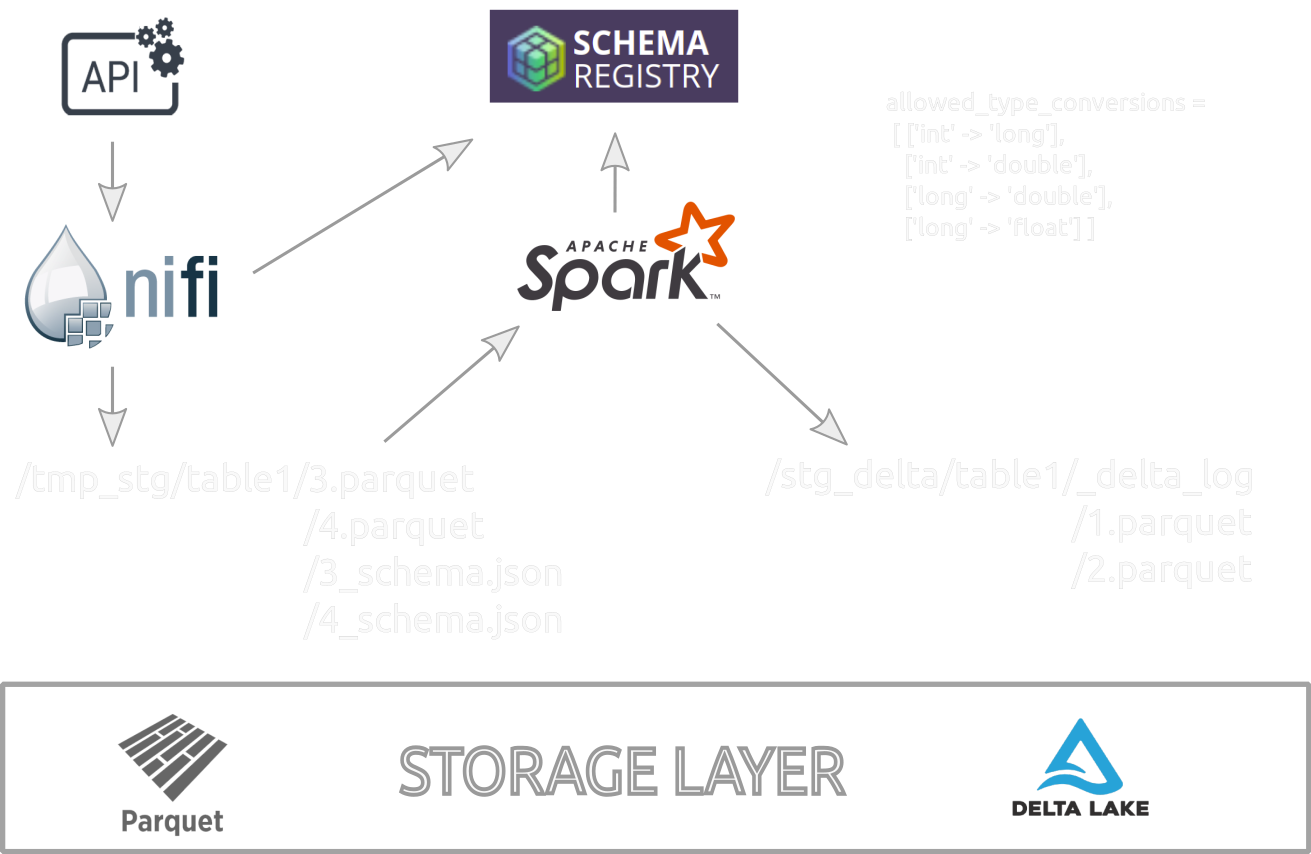

In [ ]:
spark.stop()

> Try it yourself: `Github kentore82/python-snippets`